## Interface2018/06 

辰岡さんが使われたデータは、
- https://physionet.org/physiobank/database/mitdb/

データの変換にはwfdbパッケージが必要です。以下のコマンドでインストールしてください。

```bash
$ pip install wfdb
```

MIT-BIH Arrhythmia Databaseからダウンロードした234のデータは、mitdbディレクトリにセットします。

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import wfdb
import collections
import time

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# seaborn 0.8から以下の処理が必要になった
sns.set()

In [2]:
RECORD_NAME = '234'

DB_DIR = 'mitdb/'
SAVE_FOLDER_PATH = '.' + os.sep + 'ecg_data'

def load_data_ecg(rec_name=RECORD_NAME, begin_idx=0, end_idx=0, N=200):
    """
        Load specified ECG data from MIT-BIH Arrhythmia Database
        and remove baseline drift artifact.
    
        Parameters:
            rec_name    Record name 
            begin_idx   Begin index
            end_idx     End index
            N           Range of moving averaging for removing drift baseline
        Returns:
            rec         wfdb.io.record.Record object (Original waveform)
            ann         wfdb.io.annotation.Annotation object
            rec2        wfdb.io.record.Record object (After removing drift)
                        (Data length is N * 200 fewer than original)
        Usage:
            1)  load_data_ecg('234')  # for entire data length
            2)  load_data_ecg('234', begin_idx=148000, end_idx=152000)
    """
    # Data file hostd on Physiobank
    if end_idx == 0:
        rec = wfdb.rdrecord(rec_name, pb_dir = DB_DIR)
    else:
        rec = wfdb.rdrecord(rec_name, pb_dir = DB_DIR, sampfrom=begin_idx - N, sampto=end_idx + N)
    print('\n\nRecord data:')
    print(vars(rec))
    
    # Draw waveforms
    wfdb.plot_wfdb(record=rec, title='Record '+rec_name) 
    
    # Read header file
    hdr = wfdb.rdheader(rec_name, pb_dir=DB_DIR)
    print('\n\nHeader data:')
    print(vars(hdr))

    # Annotation file
    if end_idx == 0:
        ann = wfdb.rdann(rec_name, 'atr', pb_dir=DB_DIR)
    else:
        ann = wfdb.rdann(rec_name, 'atr', pb_dir=DB_DIR, sampfrom=begin_idx - N, sampto=end_idx + N)
        ann.sample = ann.sample - (begin_idx - N)

    print('\n\nAnnotation data:')
    print(ann.ann_len)
    print('\n\nIndex of anomaly data:')
    print(collections.Counter(ann.symbol))
    ano = ann.sample[np.where(np.array(ann.symbol) != 'N')]
    astr = np.array(ann.symbol)[np.where(np.array(ann.symbol) != 'N')] 
    print("Annotation: " + str(len(ano)) + ' beats')
    for (i, a) in zip(ano, astr):
        print(str(i) + "\t" + a)        

    # Draw waveforms    
    wfdb.plot_wfdb(record=rec, annotation=ann,
                   title='Record ' + rec_name + ' with annotation',
                   time_units='seconds')
    
    # Removed baseline drift artifact
    M = 2 * N + 1
    dat_len = rec.p_signal.shape[0] - 2 * N
    ch_num = rec.p_signal.shape[1]

    b = np.ones(M) / float(M)
    start_time = time.time()
    drift_wave = np.zeros((dat_len, ch_num), dtype=np.int16)
    if end_idx == 0:
        rec2 = wfdb.rdrecord(rec_name, pb_dir = DB_DIR, sampfrom=N, sampto=N+dat_len)
    else:
        rec2 = wfdb.rdrecord(rec_name, pb_dir = DB_DIR, sampfrom=begin_idx, sampto=end_idx)

    for i in range(ch_num):
         drift_wave = np.convolve(rec.p_signal[:,i], b, 'valid')
         rec2.p_signal[:,i] = rec2.p_signal[:,i] - drift_wave
    elapsed_time = time.time() - start_time
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    
    # Draw waveforms
    wfdb.plot_wfdb(record=rec2, title='Record '+rec_name + ' removed baseline drift') 
    
    # Save waveforms
    if not os.path.exists(SAVE_FOLDER_PATH):
        os.mkdir(SAVE_FOLDER_PATH)
    if end_idx == 0:
        file_name = 'wave_data_' + rec_name
    else:
        file_name = 'wave_data_' + rec_name + "_" + str(begin_idx) + "_" + str(begin_idx+dat_len)
    wave_dat_path = os.path.join(SAVE_FOLDER_PATH, file_name + '.pkl')
    wave_csv_path = os.path.join(SAVE_FOLDER_PATH, file_name + '.csv')
    wave_data = pd.DataFrame(rec2.p_signal)
    with open(wave_dat_path,'wb') as f:
        pickle.dump(wave_data, f)
    wave_data.to_csv(wave_csv_path, index=False)
    
    return rec, ann, rec2



Record data:
{'base_time': None, 'base_counter': None, 'sig_name': ['MLII', 'V1'], 'file_name': ['234.dat', '234.dat'], 'init_value': [850, 1068], 'base_date': None, 'block_size': [0, 0], 'counter_freq': None, 'baseline': [1024, 1024], 'adc_gain': [200.0, 200.0], 'fmt': ['212', '212'], 'byte_offset': [None, None], 'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.'], 'units': ['mV', 'mV'], 'sig_len': 4400, 'e_p_signal': None, 'fs': 360, 'record_name': '234', 'n_sig': 2, 'samps_per_frame': [1, 1], 'adc_res': [11, 11], 'd_signal': None, 'skew': [None, None], 'checksum': [32719, 17835], 'p_signal': array([[-0.87 ,  0.22 ],
       [-1.02 ,  0.04 ],
       [-1.105, -0.105],
       ..., 
       [-0.06 ,  0.14 ],
       [-0.05 ,  0.155],
       [-0.03 ,  0.17 ]]), 'adc_zero': [1024, 1024], 'e_d_signal': None}


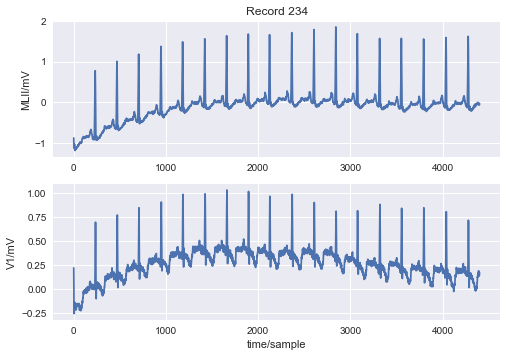



Header data:
{'base_time': None, 'base_counter': None, 'sig_name': ['MLII', 'V1'], 'file_name': ['234.dat', '234.dat'], 'init_value': [1008, 1051], 'base_date': None, 'block_size': [0, 0], 'counter_freq': None, 'baseline': [1024, 1024], 'adc_gain': [200.0, 200.0], 'fmt': ['212', '212'], 'byte_offset': [None, None], 'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.'], 'units': ['mV', 'mV'], 'sig_len': 650000, 'e_p_signal': None, 'fs': 360, 'record_name': '234', 'n_sig': 2, 'samps_per_frame': [1, 1], 'adc_res': [11, 11], 'd_signal': None, 'skew': [None, None], 'checksum': [18427, 21057], 'p_signal': None, 'adc_zero': [1024, 1024], 'e_d_signal': None}


Annotation data:
18


Index of anomaly data:
Counter({'N': 18})
Annotation: 0 beats


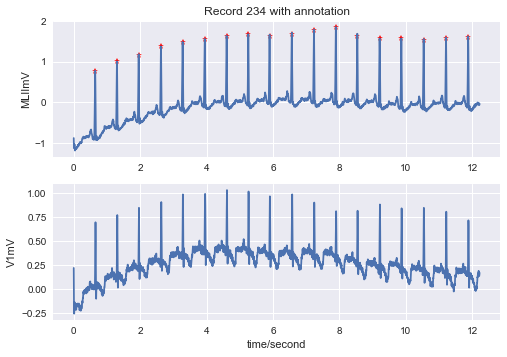

elapsed_time:0.810350894928[sec]


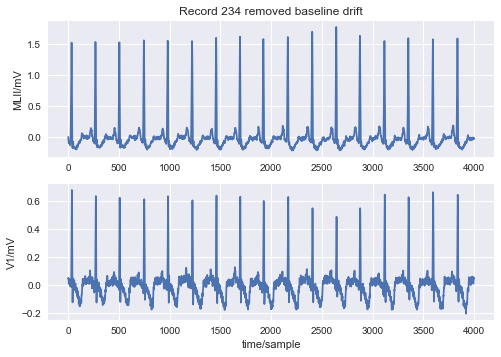



Record data:
{'base_time': None, 'base_counter': None, 'sig_name': ['MLII', 'V1'], 'file_name': ['234.dat', '234.dat'], 'init_value': [1030, 1057], 'base_date': None, 'block_size': [0, 0], 'counter_freq': None, 'baseline': [1024, 1024], 'adc_gain': [200.0, 200.0], 'fmt': ['212', '212'], 'byte_offset': [None, None], 'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.'], 'units': ['mV', 'mV'], 'sig_len': 4400, 'e_p_signal': None, 'fs': 360, 'record_name': '234', 'n_sig': 2, 'samps_per_frame': [1, 1], 'adc_res': [11, 11], 'd_signal': None, 'skew': [None, None], 'checksum': [6594, 28628], 'p_signal': array([[ 0.03 ,  0.165],
       [ 0.015,  0.17 ],
       [ 0.015,  0.185],
       ..., 
       [-0.76 ,  0.035],
       [-0.76 ,  0.055],
       [-0.775,  0.045]]), 'adc_zero': [1024, 1024], 'e_d_signal': None}


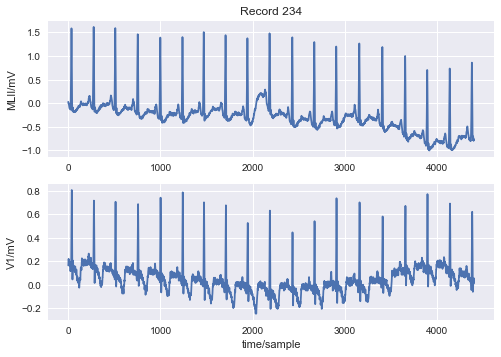



Header data:
{'base_time': None, 'base_counter': None, 'sig_name': ['MLII', 'V1'], 'file_name': ['234.dat', '234.dat'], 'init_value': [1008, 1051], 'base_date': None, 'block_size': [0, 0], 'counter_freq': None, 'baseline': [1024, 1024], 'adc_gain': [200.0, 200.0], 'fmt': ['212', '212'], 'byte_offset': [None, None], 'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.'], 'units': ['mV', 'mV'], 'sig_len': 650000, 'e_p_signal': None, 'fs': 360, 'record_name': '234', 'n_sig': 2, 'samps_per_frame': [1, 1], 'adc_res': [11, 11], 'd_signal': None, 'skew': [None, None], 'checksum': [18427, 21057], 'p_signal': None, 'adc_zero': [1024, 1024], 'e_d_signal': None}


Annotation data:
19


Index of anomaly data:
Counter({'N': 19})
Annotation: 0 beats


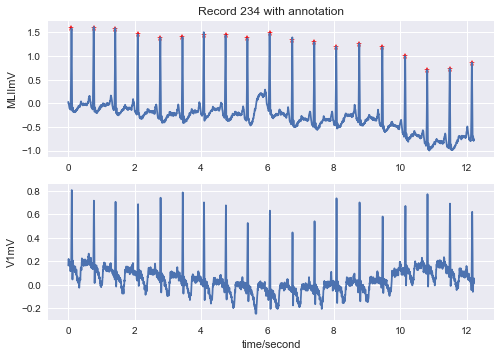

elapsed_time:0.811053991318[sec]


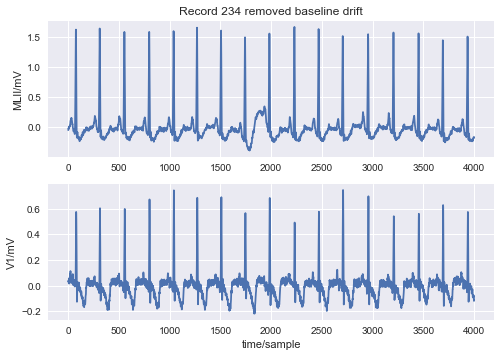

done


In [5]:
load_data_ecg('234', begin_idx=148000, end_idx=152000)
load_data_ecg('234', begin_idx=152000, end_idx=156000)

In [6]:
from sklearn.preprocessing import MinMaxScaler

from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.utils.vis_utils import plot_model


Using TensorFlow backend.


In [7]:
sns.reset_orig()

def conv_norm(x):
    """ Convert to normalized data
    """
    ms = MinMaxScaler()
    return ms.fit_transform(pd.DataFrame(x))

def conv_subseq(x, w):
    """ Convert to subsequence time series
    """
    subseq_size = len(x) - w + 1
    subseq = np.zeros((subseq_size, w))
    for i in range(subseq_size):
        start_idx = i
        end_idx = w + i
        subseq[i,:] = x[start_idx:end_idx].flatten()
    return subseq


In [8]:
folder_path='AI'
train_file_name='wave_data_234_148000_152000.pkl'  # Train pickle file
test_file_name='wave_data_234_152000_156000.pkl'   # Test pickle file
half_sr_mode=False      # Sampling rate (True:180Hz, False:360Hz)
in_out_size=100            # Subsequence time series size
hidden_size=160            # Hidden layer unit sizze

# Arias
window_size = in_out_size
encoding_dim = hidden_size

# Setup data
FOLDER_PATH = '.' + os.sep + folder_path
if not os.path.exists(FOLDER_PATH):
    os.mkdir(FOLDER_PATH)

DATA_FOLDER_PATH = 'ecg_data'    # Saved folder of pickle data files
TRAIN_FILE_NAME = os.path.join(DATA_FOLDER_PATH, train_file_name)
TEST_FILE_NAME = os.path.join(DATA_FOLDER_PATH, test_file_name)

with open(TRAIN_FILE_NAME, 'rb') as f:
    train_dat = (pickle.load(f)).iloc[:,0]  # Only channel 1

with open(TEST_FILE_NAME, 'rb') as f:
    test_dat = (pickle.load(f)).iloc[:,0]   # Only channel 1

# Decimate data in half sampling rate mode
if half_sr_mode:
    train_dat = pd.Series(np.array(train_dat[::2]) +
                          np.array(train_dat[1::2])) / 2
    test_dat = pd.Series(np.array(test_dat[::2]) +
                         np.array(test_dat[1::2])) / 2

# Normalization
train_dat_norm = conv_norm(train_dat)
test_dat_norm = conv_norm(test_dat)

# Generate subsequence time series
train_dat_s = conv_subseq(train_dat_norm, window_size)
test_dat_s = conv_subseq(test_dat_norm, window_size)

x_train = train_dat_s.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


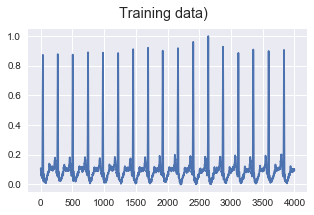

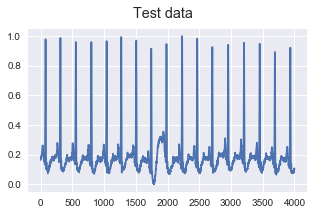

In [10]:
# Plot training data
sns.set()

plt.figure(figsize=(5,3))
plt.plot(train_dat_norm)
plt.suptitle('Training data)')
plt.show()

# Plot test data
plt.figure(figsize=(5,3))
plt.plot(test_dat_norm)
plt.suptitle('Test data')
plt.show()

In [26]:
encoder_act='relu'         # Activation function for encoder
decoder_act='relu'         # Activation function for decoder
reg_l1=10e-7                 # L1 regularization coefficient value
reg_l2=0.0                      # L2 regularization coefficient value
opt_alg='adadelta'         # Optimizer algorithm
loss_func='binary_crossentropy' # loss function
batch_size=None            # Size of mini-batch gradient descent
epoch_num=5000           # 3000

""" Detecting anomaly points """
# Define model
input_layer = Input(shape=(window_size,), name='Input')
encoded = Dense(encoding_dim, activation=encoder_act, name='Encoder',
                activity_regularizer=regularizers.l1(reg_l1))(input_layer)
decoded = Dense(window_size, activation=decoder_act, name='Decoder')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Generate model
autoencoder.compile(optimizer=opt_alg, loss=loss_func)

# Train model
history = autoencoder.fit(x_train, x_train,
                          epochs=epoch_num,
                          batch_size=batch_size,
                          verbose=1,
                          shuffle=True)


Epoch 1/5000
3901/3901 [==============================] - 1s 141us/step - loss: 0.5621
Epoch 2/5000
3901/3901 [==============================] - 0s 117us/step - loss: 0.4354
Epoch 3/5000
3901/3901 [==============================] - 1s 144us/step - loss: 0.4147
Epoch 4/5000
3901/3901 [==============================] - 0s 110us/step - loss: 0.4088
Epoch 5/5000
3901/3901 [==============================] - 0s 106us/step - loss: 0.4018
Epoch 6/5000
3901/3901 [==============================] - 0s 108us/step - loss: 0.3885
Epoch 7/5000
3901/3901 [==============================] - 0s 114us/step - loss: 0.3864
Epoch 8/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.3842
Epoch 9/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.3703
Epoch 10/5000
3901/3901 [==============================] - 0s 112us/step - loss: 0.3691
Epoch 11/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.3683
Epoch 12/5000
3901/3901 [================

3901/3901 [==============================] - 0s 102us/step - loss: 0.3508
Epoch 187/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.3508
Epoch 188/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.3508
Epoch 189/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.3508
Epoch 190/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.3508
Epoch 191/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.3508
Epoch 192/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.3508
Epoch 193/5000
3901/3901 [==============================] - 0s 113us/step - loss: 0.3508
Epoch 194/5000
3901/3901 [==============================] - 0s 107us/step - loss: 0.3508
Epoch 195/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.3508
Epoch 196/5000
3901/3901 [==============================] - 0s 110us/step - loss: 0.3508
Epoch 197/5000
3901/3901 [===============

3901/3901 [==============================] - 0s 94us/step - loss: 0.3508
Epoch 279/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.3507
Epoch 280/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.3507
Epoch 281/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.3507
Epoch 282/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.3507
Epoch 283/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.3507
Epoch 284/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.3507
Epoch 285/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.3507
Epoch 286/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.3507
Epoch 287/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.3507
Epoch 288/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.3507
Epoch 289/5000
3901/3901 [=================

3901/3901 [==============================] - 0s 103us/step - loss: 0.3050
Epoch 462/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.3050
Epoch 463/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.3050
Epoch 464/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.3050
Epoch 465/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.3050
Epoch 466/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.3050
Epoch 467/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.3050
Epoch 468/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.3050
Epoch 469/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.3050
Epoch 470/5000
3901/3901 [==============================] - 0s 106us/step - loss: 0.3050
Epoch 471/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.3050
Epoch 472/5000
3901/3901 [=============

Epoch 645/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2897
Epoch 646/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2897
Epoch 647/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2896
Epoch 648/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2897
Epoch 649/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2897
Epoch 650/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2897
Epoch 651/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2897
Epoch 652/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2897
Epoch 653/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2897
Epoch 654/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 655/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2897
Epoch 656/5000
3901/3901

3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 829/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2897
Epoch 830/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2896
Epoch 831/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2897
Epoch 832/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2896
Epoch 833/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2896
Epoch 834/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 835/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2897
Epoch 836/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2896 0s - loss: 
Epoch 837/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2897
Epoch 838/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2897
Epoch 839/5000
3901/3901 

3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 921/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.2896
Epoch 922/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 923/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2896
Epoch 924/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2896
Epoch 925/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 926/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2896
Epoch 927/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.2896
Epoch 928/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2896
Epoch 929/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2896
Epoch 930/5000
3901/3901 [==============================] - 0s 106us/step - loss: 0.2896
Epoch 931/5000
3901/3901 [=================

3901/3901 [==============================] - 0s 112us/step - loss: 0.2897
Epoch 1103/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1104/5000
3901/3901 [==============================] - 0s 110us/step - loss: 0.2896
Epoch 1105/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1106/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1107/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 1108/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1109/5000
3901/3901 [==============================] - 0s 111us/step - loss: 0.2896
Epoch 1110/5000
3901/3901 [==============================] - 0s 108us/step - loss: 0.2896
Epoch 1111/5000
3901/3901 [==============================] - 0s 115us/step - loss: 0.2898
Epoch 1112/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1113/5000
3901/3901 

3901/3901 [==============================] - 0s 103us/step - loss: 0.2897
Epoch 1284/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2896
Epoch 1285/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1286/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1287/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2896
Epoch 1288/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1289/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 1290/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1291/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2896
Epoch 1292/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1293/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.2896
Epoch 1294/5000
3901/3901 

3901/3901 [==============================] - 0s 106us/step - loss: 0.2896
Epoch 1464/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1465/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2899
Epoch 1466/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 1467/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1468/5000
3901/3901 [==============================] - 0s 106us/step - loss: 0.2896
Epoch 1469/5000
3901/3901 [==============================] - 0s 111us/step - loss: 0.2896
Epoch 1470/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1471/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 1472/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1473/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1474/5000
3901/3901 

3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1645/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1646/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1647/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2896
Epoch 1648/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2896
Epoch 1649/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1650/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 1651/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2896
Epoch 1652/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2896
Epoch 1653/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2896
Epoch 1654/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1655/5000
3901/3901 [

3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1827/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2895
Epoch 1828/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2896
Epoch 1829/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1830/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2896
Epoch 1831/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2895
Epoch 1832/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2895
Epoch 1833/5000
3901/3901 [==============================] - 0s 108us/step - loss: 0.2896
Epoch 1834/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 1835/5000
3901/3901 [==============================] - 0s 114us/step - loss: 0.2896
Epoch 1836/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2896
Epoch 1837/5000
3901/3901 [=

3901/3901 [==============================] - 0s 106us/step - loss: 0.2895
Epoch 1918/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.2896
Epoch 1919/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 1920/5000
3901/3901 [==============================] - 0s 112us/step - loss: 0.2895
Epoch 1921/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.2895
Epoch 1922/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.2895
Epoch 1923/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 1924/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2896
Epoch 1925/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 1926/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 1927/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2896
Epoch 1928/5000
3901/3901 [=====

3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2100/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 2101/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2102/5000
3901/3901 [==============================] - ETA: 0s - loss: 0.290 - 0s 92us/step - loss: 0.2896
Epoch 2103/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2104/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2105/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 2106/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 2107/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2108/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 2109/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2897
Epoch 2110/50

Epoch 2282/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 2283/5000
3901/3901 [==============================] - 0s 120us/step - loss: 0.2898
Epoch 2284/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2897
Epoch 2285/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2895
Epoch 2286/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 2287/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2896
Epoch 2288/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 2289/5000
3901/3901 [==============================] - 0s 90us/step - loss: 0.2897
Epoch 2290/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2896
Epoch 2291/5000
3901/3901 [==============================] - 0s 90us/step - loss: 0.2895
Epoch 2292/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2896
Epoch 2293/5000
390

3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2465/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2466/5000
3901/3901 [==============================] - 0s 90us/step - loss: 0.2895
Epoch 2467/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2468/5000
3901/3901 [==============================] - 0s 90us/step - loss: 0.2895
Epoch 2469/5000
3901/3901 [==============================] - 0s 108us/step - loss: 0.2895
Epoch 2470/5000
3901/3901 [==============================] - 0s 119us/step - loss: 0.2895
Epoch 2471/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2896
Epoch 2472/5000
3901/3901 [==============================] - 1s 128us/step - loss: 0.2896
Epoch 2473/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2474/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 2475/5000
3901/3901 [=======

3901/3901 [==============================] - 0s 117us/step - loss: 0.2895
Epoch 2557/5000
3901/3901 [==============================] - 0s 128us/step - loss: 0.2895
Epoch 2558/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2895
Epoch 2559/5000
3901/3901 [==============================] - 0s 114us/step - loss: 0.2895
Epoch 2560/5000
3901/3901 [==============================] - 0s 119us/step - loss: 0.2895
Epoch 2561/5000
3901/3901 [==============================] - 0s 117us/step - loss: 0.2895
Epoch 2562/5000
3901/3901 [==============================] - 1s 142us/step - loss: 0.2895
Epoch 2563/5000
3901/3901 [==============================] - 1s 149us/step - loss: 0.2895
Epoch 2564/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2895
Epoch 2565/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2895
Epoch 2566/5000
3901/3901 [==============================] - 0s 111us/step - loss: 0.2895
Epoch 2567/5000
3901/3901 [

3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 2739/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 2740/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2896
Epoch 2741/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 2742/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 2743/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 2744/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 2745/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 2746/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 2747/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 2748/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 2749/5000
3901/3901 [==========

3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 2922/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2923/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 2924/5000
3901/3901 [==============================] - 0s 90us/step - loss: 0.2895
Epoch 2925/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2898
Epoch 2926/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 2927/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 2928/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2929/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2896
Epoch 2930/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 2931/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 2932/5000
3901/3901 [==========

3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 3104/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 3105/5000
3901/3901 [==============================] - 0s 123us/step - loss: 0.2897
Epoch 3106/5000
3901/3901 [==============================] - 0s 119us/step - loss: 0.2895
Epoch 3107/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2896
Epoch 3108/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 3109/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2895
Epoch 3110/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 3111/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 3112/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.2896
Epoch 3113/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.2895
Epoch 3114/5000
3901/3901 [=======

3901/3901 [==============================] - 0s 101us/step - loss: 0.2895
Epoch 3286/5000
3901/3901 [==============================] - 1s 148us/step - loss: 0.2895
Epoch 3287/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 3288/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 3289/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2895
Epoch 3290/5000
3901/3901 [==============================] - 1s 138us/step - loss: 0.2895
Epoch 3291/5000
3901/3901 [==============================] - 0s 126us/step - loss: 0.2895
Epoch 3292/5000
3901/3901 [==============================] - 1s 136us/step - loss: 0.2895
Epoch 3293/5000
3901/3901 [==============================] - 1s 162us/step - loss: 0.2897
Epoch 3294/5000
3901/3901 [==============================] - 1s 135us/step - loss: 0.2895
Epoch 3295/5000
3901/3901 [==============================] - 0s 121us/step - loss: 0.2895
Epoch 3296/5000
3901/3901 

3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 3468/5000
3901/3901 [==============================] - ETA: 0s - loss: 0.289 - 0s 93us/step - loss: 0.2895
Epoch 3469/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 3470/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 3471/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 3472/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 3473/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 3474/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 3475/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 3476/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 3477/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2895
Epoch 3478/5

3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 3650/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 3651/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 3652/5000
3901/3901 [==============================] - 0s 111us/step - loss: 0.2896
Epoch 3653/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 3654/5000
3901/3901 [==============================] - 1s 130us/step - loss: 0.2895
Epoch 3655/5000
3901/3901 [==============================] - 1s 131us/step - loss: 0.2895
Epoch 3656/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2895
Epoch 3657/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2895
Epoch 3658/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 3659/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 3660/5000
3901/3901 [====

3901/3901 [==============================] - 0s 125us/step - loss: 0.2895
Epoch 3831/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2896
Epoch 3832/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2895
Epoch 3833/5000
3901/3901 [==============================] - 0s 117us/step - loss: 0.2895
Epoch 3834/5000
3901/3901 [==============================] - 0s 128us/step - loss: 0.2895
Epoch 3835/5000
3901/3901 [==============================] - 0s 124us/step - loss: 0.2895
Epoch 3836/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2895
Epoch 3837/5000
3901/3901 [==============================] - 0s 126us/step - loss: 0.2895
Epoch 3838/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2895
Epoch 3839/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 3840/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 3841/5000
3901/3901 [==

Epoch 4012/5000
3901/3901 [==============================] - 0s 118us/step - loss: 0.2895
Epoch 4013/5000
3901/3901 [==============================] - 0s 128us/step - loss: 0.2895
Epoch 4014/5000
3901/3901 [==============================] - 0s 117us/step - loss: 0.2897
Epoch 4015/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2896
Epoch 4016/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2895
Epoch 4017/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 4018/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4019/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2895
Epoch 4020/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2895
Epoch 4021/5000
3901/3901 [==============================] - 0s 97us/step - loss: 0.2895
Epoch 4022/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4023/500

3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 4196/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4197/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 4198/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4199/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4200/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4201/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4202/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 4203/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 4204/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 4205/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4206/5000
3901/3901 [==========

3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4288/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4289/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4290/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 4291/5000
3901/3901 [==============================] - 0s 119us/step - loss: 0.2895
Epoch 4292/5000
3901/3901 [==============================] - 0s 107us/step - loss: 0.2895
Epoch 4293/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2895
Epoch 4294/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 4295/5000
3901/3901 [==============================] - 0s 94us/step - loss: 0.2895
Epoch 4296/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4297/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4298/5000
3901/3901 [=======

Epoch 4471/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2895
Epoch 4472/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4473/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 4474/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2895
Epoch 4475/5000
3901/3901 [==============================] - 0s 105us/step - loss: 0.2895
Epoch 4476/5000
3901/3901 [==============================] - 0s 112us/step - loss: 0.2895
Epoch 4477/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2895
Epoch 4478/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2895
Epoch 4479/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4480/5000
3901/3901 [==============================] - 0s 98us/step - loss: 0.2895
Epoch 4481/5000
3901/3901 [==============================] - 0s 99us/step - loss: 0.2895
Epoch 4482/5000

3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4655/5000
3901/3901 [==============================] - 0s 91us/step - loss: 0.2895
Epoch 4656/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 4657/5000
3901/3901 [==============================] - 0s 96us/step - loss: 0.2895
Epoch 4658/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 4659/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2896
Epoch 4660/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4661/5000
3901/3901 [==============================] - 0s 92us/step - loss: 0.2895
Epoch 4662/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4663/5000
3901/3901 [==============================] - 0s 93us/step - loss: 0.2895
Epoch 4664/5000
3901/3901 [==============================] - 0s 95us/step - loss: 0.2895
Epoch 4665/5000
3901/3901 [==========

Epoch 4746/5000
3901/3901 [==============================] - 0s 112us/step - loss: 0.2895
Epoch 4747/5000
3901/3901 [==============================] - 0s 120us/step - loss: 0.2895
Epoch 4748/5000
3901/3901 [==============================] - 0s 111us/step - loss: 0.2895
Epoch 4749/5000
3901/3901 [==============================] - 0s 109us/step - loss: 0.2895
Epoch 4750/5000
3901/3901 [==============================] - 1s 134us/step - loss: 0.2895
Epoch 4751/5000
3901/3901 [==============================] - 0s 116us/step - loss: 0.2895
Epoch 4752/5000
3901/3901 [==============================] - 0s 121us/step - loss: 0.2895
Epoch 4753/5000
3901/3901 [==============================] - 0s 113us/step - loss: 0.2895
Epoch 4754/5000
3901/3901 [==============================] - 0s 113us/step - loss: 0.2895
Epoch 4755/5000
3901/3901 [==============================] - 0s 126us/step - loss: 0.2895
Epoch 4756/5000
3901/3901 [==============================] - 0s 116us/step - loss: 0.2895
Epoch 4757

3901/3901 [==============================] - 0s 107us/step - loss: 0.2895
Epoch 4838/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2895
Epoch 4839/5000
3901/3901 [==============================] - 0s 104us/step - loss: 0.2895
Epoch 4840/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2895
Epoch 4841/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2895
Epoch 4842/5000
3901/3901 [==============================] - 0s 110us/step - loss: 0.2895
Epoch 4843/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2895
Epoch 4844/5000
3901/3901 [==============================] - 0s 101us/step - loss: 0.2895
Epoch 4845/5000
3901/3901 [==============================] - 0s 100us/step - loss: 0.2896
Epoch 4846/5000
3901/3901 [==============================] - 0s 102us/step - loss: 0.2895
Epoch 4847/5000
3901/3901 [==============================] - 0s 103us/step - loss: 0.2895
Epoch 4848/5000
3901/3901 

('Training loss:', 0.28969318375957837)


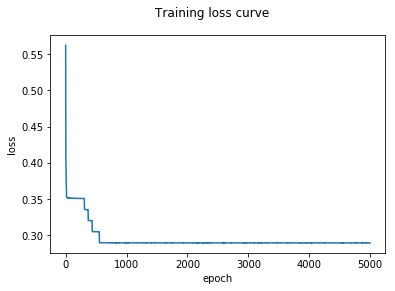

In [27]:

# Print last score
score = autoencoder.evaluate(x_train, x_train, verbose=0)
print('Training loss:', score)

# Plot loss curve
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.suptitle('Training loss curve')
plt.show()


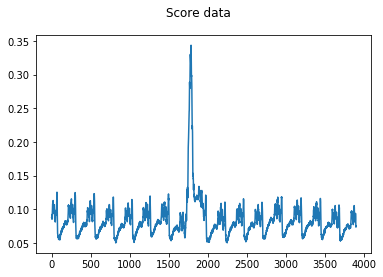

In [28]:
# Calculate score (distance)
decoded_wave = autoencoder.predict(test_dat_s)
dist = np.sqrt(np.sum((decoded_wave - test_dat_s)**2, axis=1))

# Plot score (distance)
plt.figure()
plt.plot(dist)
plt.suptitle('Score data')
plt.show()


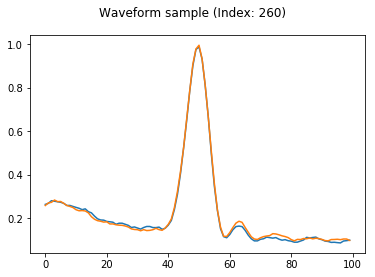

In [29]:
idx = 260
plt.figure()
plt.plot(test_dat_s[idx,:])
plt.plot(decoded_wave[idx,:])
plt.suptitle('Waveform sample (Index: ' + str(idx) + ')')
plt.show()


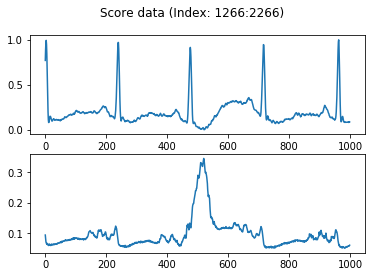

In [30]:
# Detecting over threshold
ANOMALY_TH = max(dist) * 0.8    # Threshold for score
INHIBIT_LEN = 500               # Inhibit period
an_idx = (np.where(dist>ANOMALY_TH))[0]
an_idx = an_idx[np.r_[True, (an_idx[1:]-an_idx[:-1] > INHIBIT_LEN)]]

# Plot anomaly waveform and socore
PRE_LEN = 500                   # Left margin
for idx in an_idx:
    s_idx = idx - PRE_LEN
    e_idx = idx + INHIBIT_LEN
    plt.figure()
    plt.subplot(211)
    plt.plot(test_dat_norm[s_idx:e_idx])
    plt.subplot(212)
    plt.plot(dist[s_idx:e_idx])
    plt.suptitle('Score data (Index: ' + str(s_idx) + ':' + str(e_idx) + ')')
plt.show()


In [31]:
# Save weights
save_file_prefix='1_'
save_filename = os.path.join(FOLDER_PATH, save_file_prefix + 'model_weights.h5')
autoencoder.save_weights(save_filename)

K.clear_session()
